#Shared drive ML

##EDA

#### Import necessary libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from xgboost import XGBRegressor
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import joblib
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder




In [ ]:
# prompt: remove warning

import warnings
warnings.filterwarnings('ignore')


### Load data from CSV

In [ ]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/CSV/final_internship_data.csv')

Mounted at /content/drive


###Data Overview and Initial Inspection

In [ ]:
# Step 1:
print("Data Overview:")
print(data.info())
print(data.describe())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  

###General Overview - Distributions of key numeric features

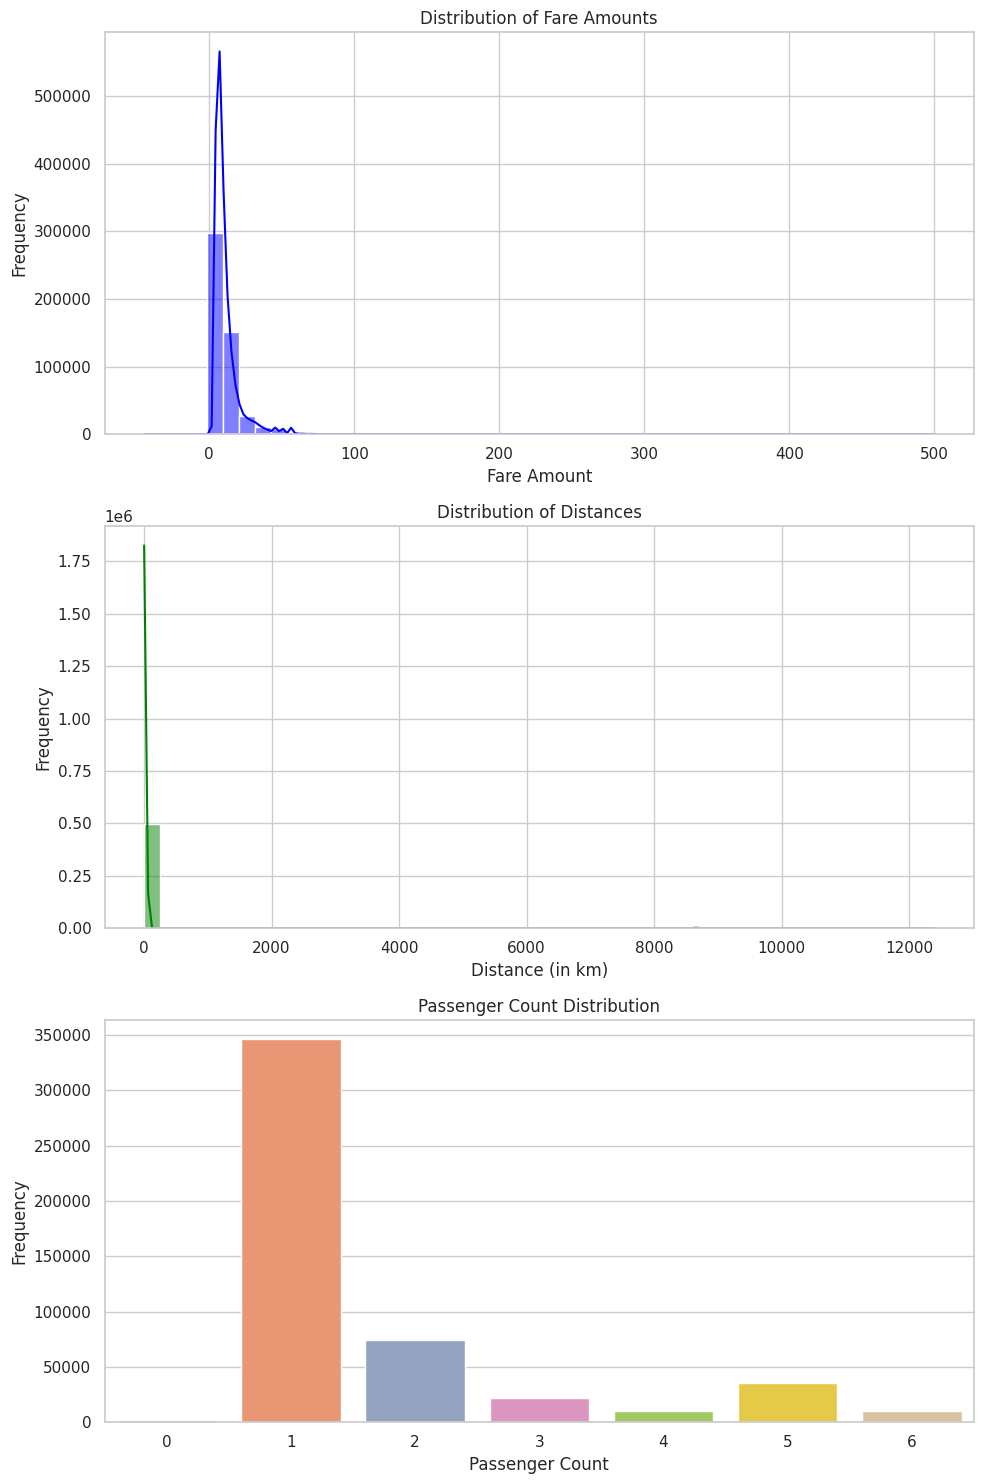

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# Plotting distributions of key numeric variables
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Fare Amount Distribution
sns.histplot(data['fare_amount'], bins=50, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Fare Amounts')
axes[0].set_xlabel('Fare Amount')
axes[0].set_ylabel('Frequency')

# Distance Distribution
sns.histplot(data['distance'], bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribution of Distances')
axes[1].set_xlabel('Distance (in km)')
axes[1].set_ylabel('Frequency')

# Passenger Count Distribution
sns.countplot(x=data['passenger_count'], palette='Set2', ax=axes[2])
axes[2].set_title('Passenger Count Distribution')
axes[2].set_xlabel('Passenger Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

###Time-Series Analysis

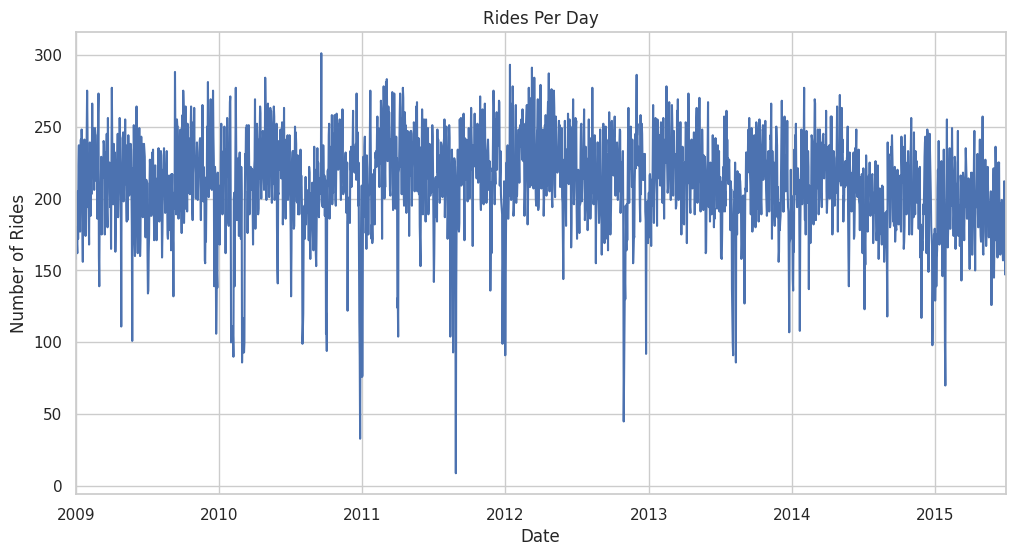

In [ ]:
# Convert 'pickup_datetime' to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Plot the number of rides over time
data.set_index('pickup_datetime', inplace=True)
rides_per_day = data.resample('D').size()

plt.figure(figsize=(12, 6))
rides_per_day.plot()
plt.title('Rides Per Day')
plt.ylabel('Number of Rides')
plt.xlabel('Date')
plt.show()

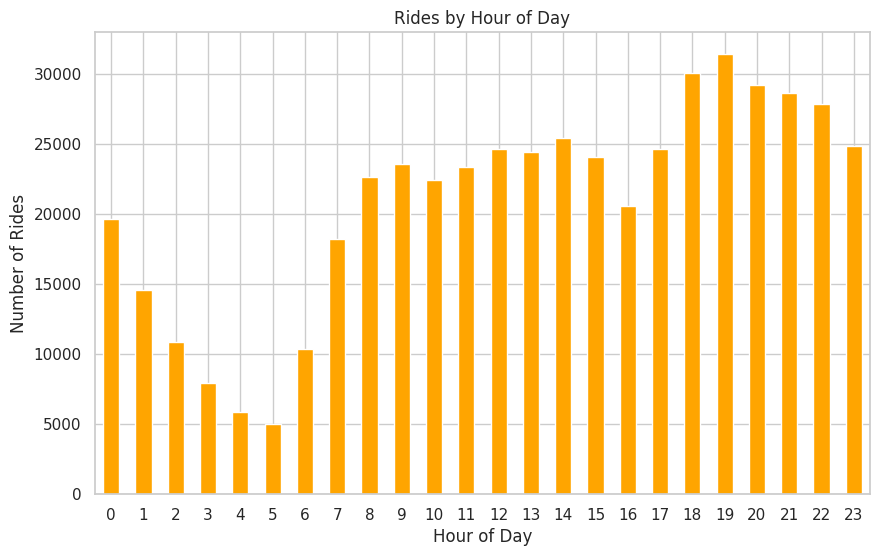

In [ ]:
# Ride frequency by hour of the day
rides_per_hour = data.groupby(data.index.hour).size()

plt.figure(figsize=(10, 6))
rides_per_hour.plot(kind='bar', color='orange')
plt.title('Rides by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.show()

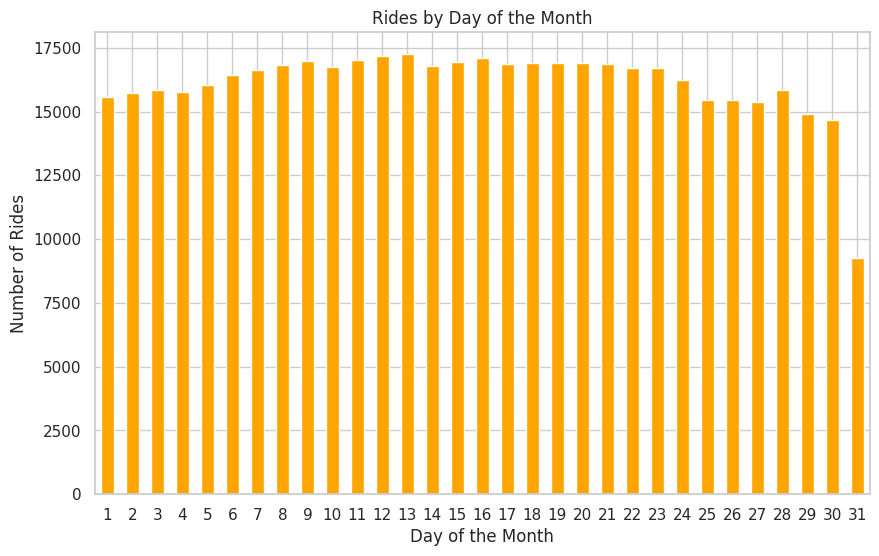

In [ ]:
rides_per_day = data.groupby('day').size()

# Plotting the number of rides by day
plt.figure(figsize=(10, 6))
rides_per_day.plot(kind='bar', color='orange')
plt.title('Rides by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.show()

###Geospatial Analysis - Pickup and Dropoff Locations


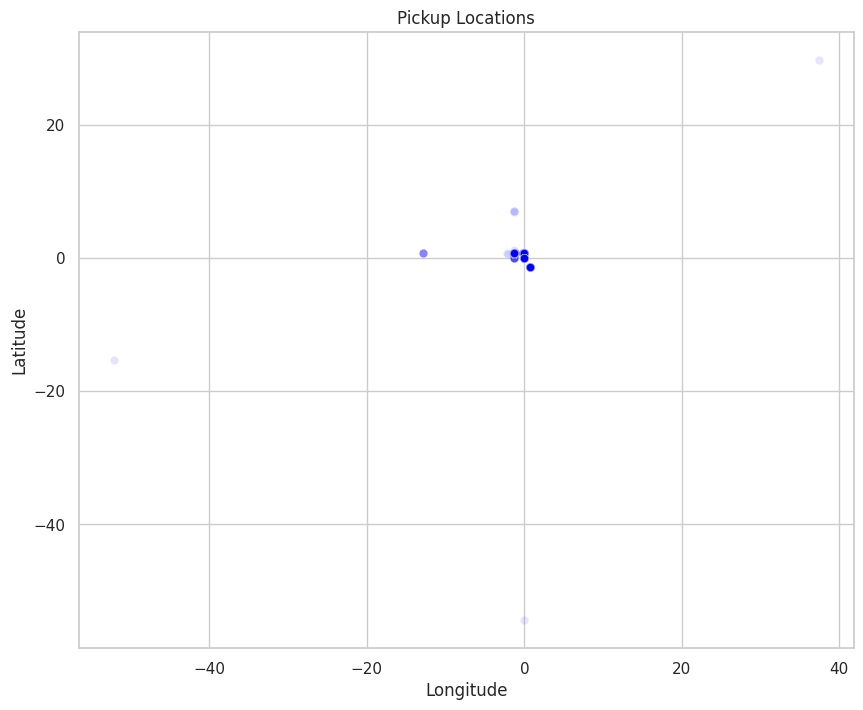

In [ ]:
# Scatter plot for pickup and dropoff locations
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data['pickup_longitude'], y=data['pickup_latitude'], alpha=0.1, color='blue')
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


 ### Correlation Analysis - Relationships between variables


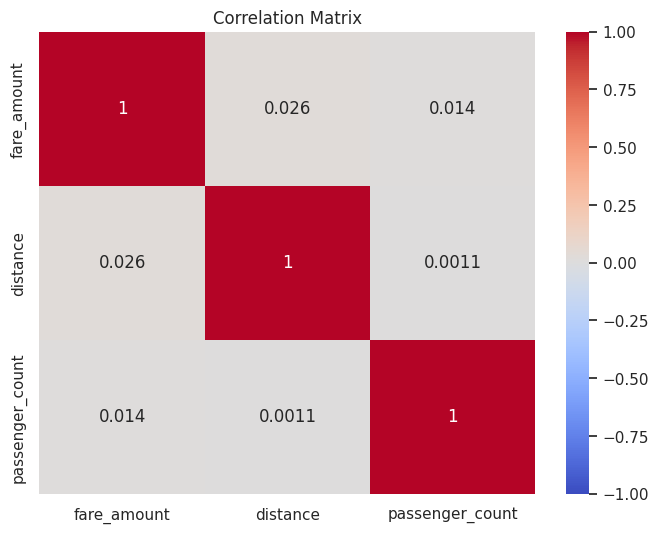

In [ ]:
# Compute the correlation matrix
corr_matrix = data[['fare_amount', 'distance', 'passenger_count']].corr()

# Plot a heatmap of the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


###Condition Analysis - Weather, Traffic, Car Condition vs. Fare Amount


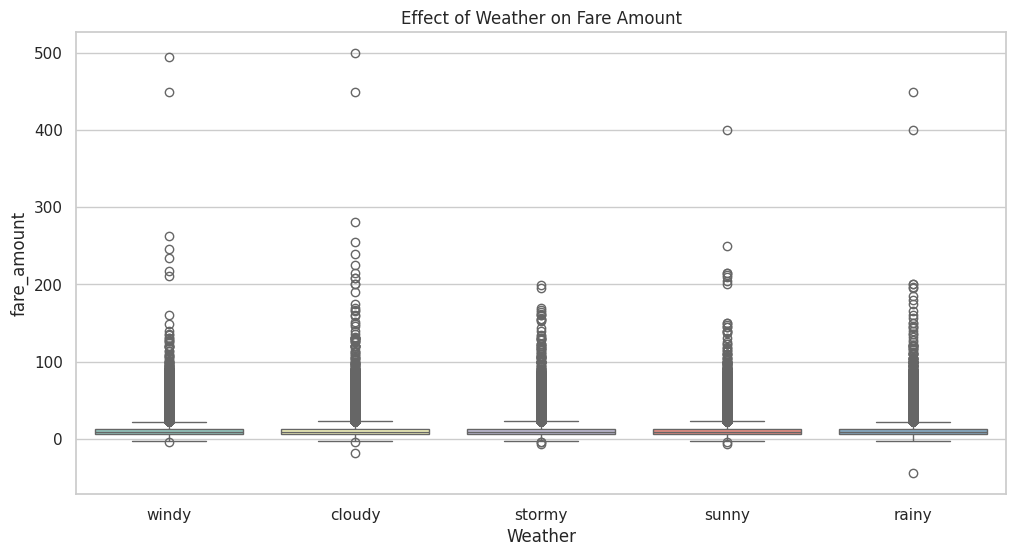

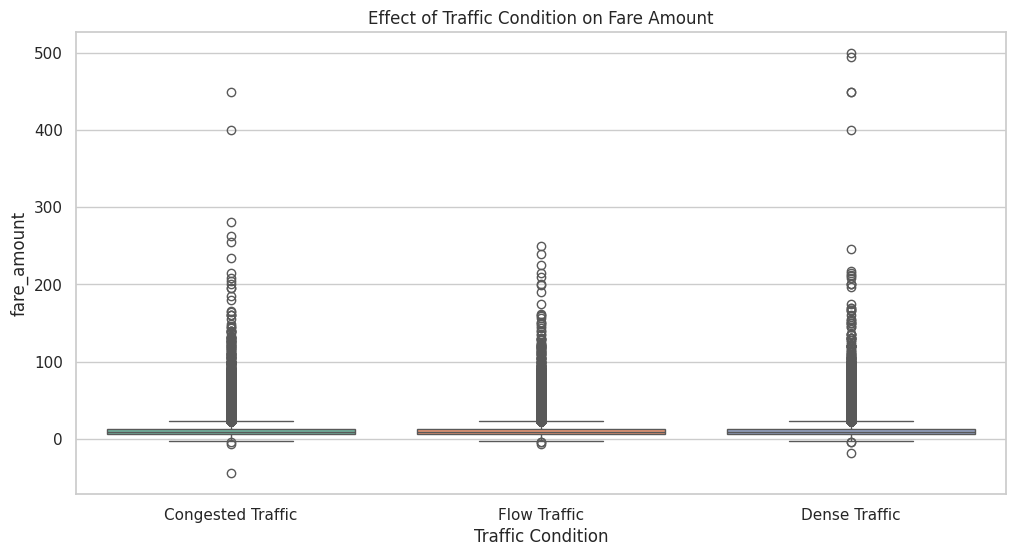

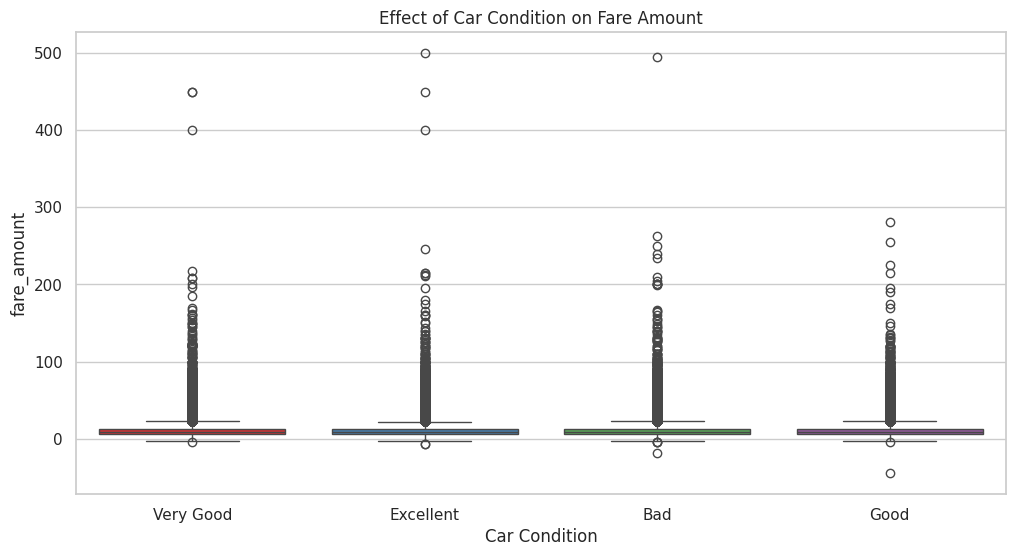

In [ ]:
# Boxplot to see the effect of Weather on Fare Amount
plt.figure(figsize=(12, 6))
sns.boxplot(x='Weather', y='fare_amount', data=data, palette='Set3')
plt.title('Effect of Weather on Fare Amount')
plt.show()

# Boxplot to analyze Traffic Condition's effect on Fare
plt.figure(figsize=(12, 6))
sns.boxplot(x='Traffic Condition', y='fare_amount', data=data, palette='Set2')
plt.title('Effect of Traffic Condition on Fare Amount')
plt.show()

# Boxplot to analyze Car Condition's effect on Fare
plt.figure(figsize=(12, 6))
sns.boxplot(x='Car Condition', y='fare_amount', data=data, palette='Set1')
plt.title('Effect of Car Condition on Fare Amount')
plt.show()

### Distribution of distances to landmarks (JFK, EWR, LGA, SOL, NYC)

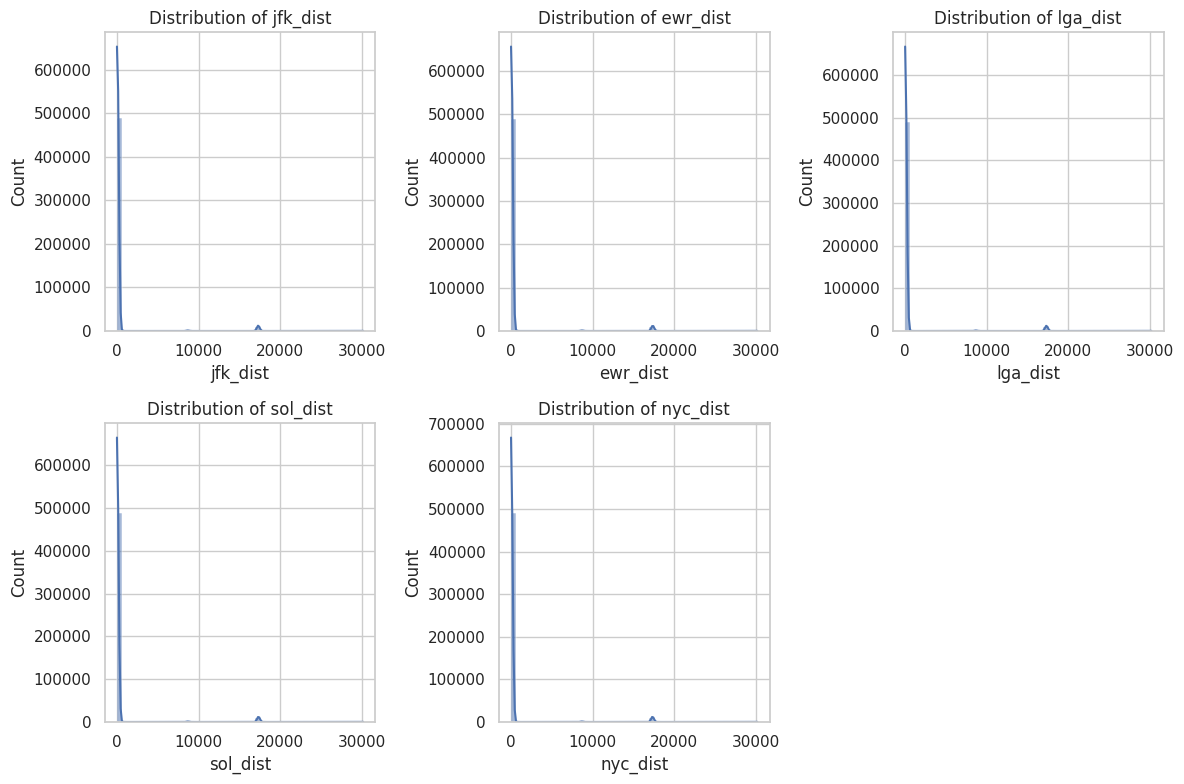

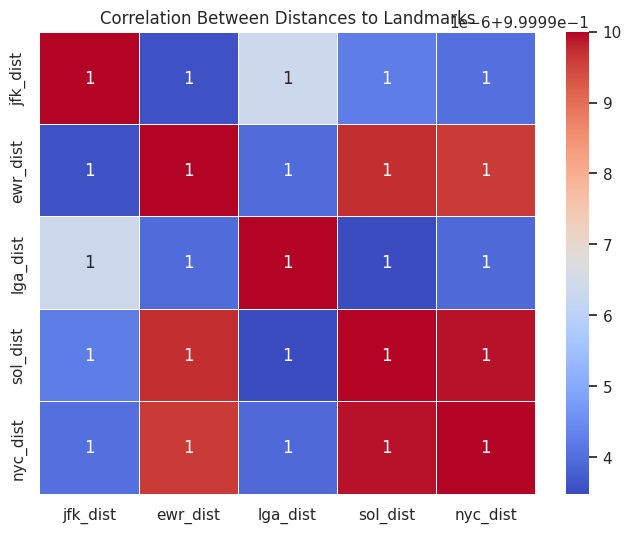

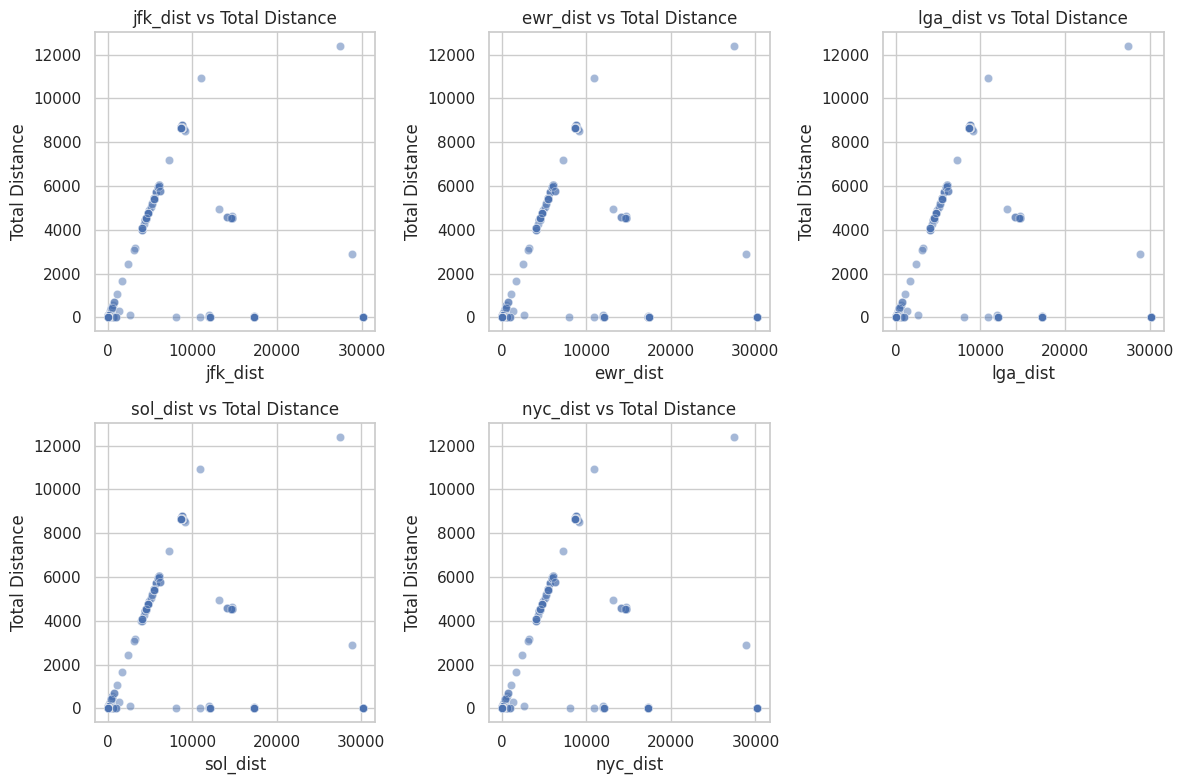

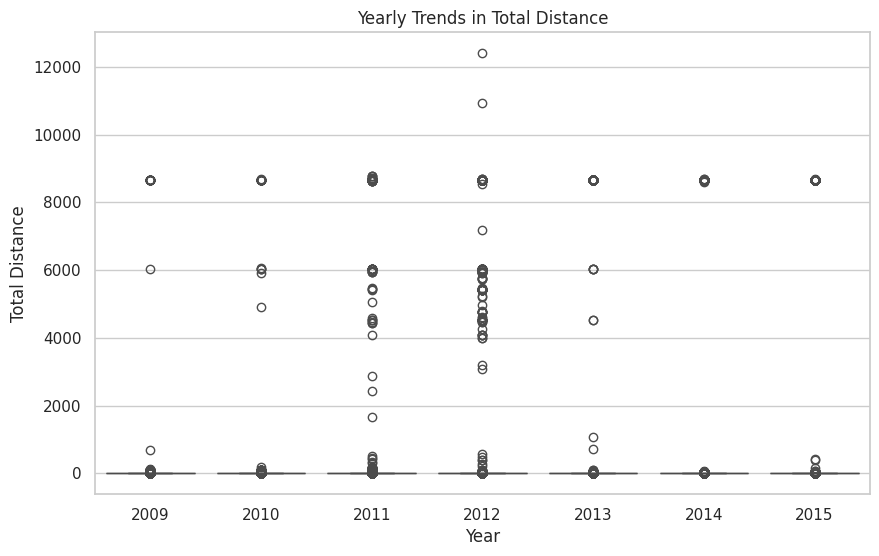

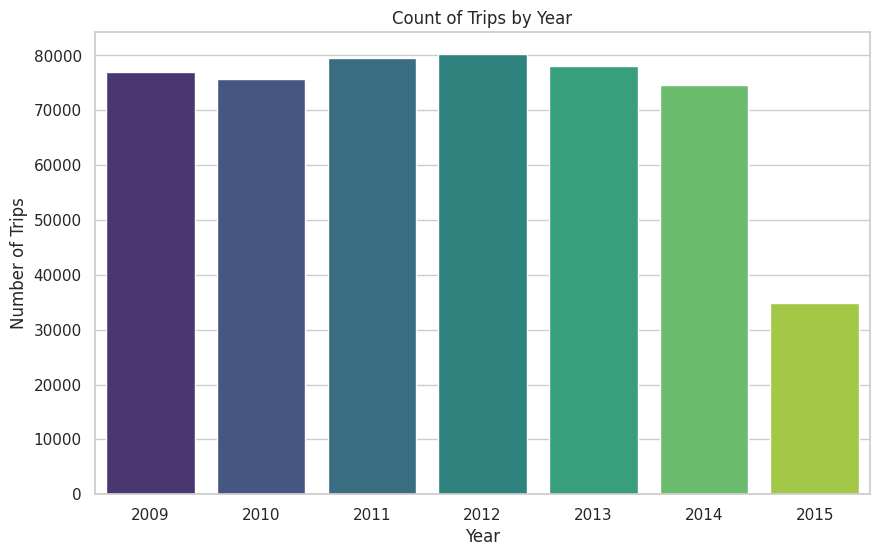

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a theme for the visualizations
sns.set_theme(style="whitegrid")

# 1. Distribution of distances to landmarks (JFK, EWR, LGA, SOL, NYC)
landmarks = ['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']

plt.figure(figsize=(12, 8))
for i, col in enumerate(landmarks, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
plt.tight_layout()
plt.show()

# 2. Correlation matrix for the distances
plt.figure(figsize=(8, 6))
corr_matrix = data[landmarks].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Distances to Landmarks')
plt.show()

# 3. Relationship between total trip distance and landmark distances
plt.figure(figsize=(12, 8))
for i, col in enumerate(landmarks, 1):
    plt.subplot(2, 3, i)
    # Reset the index of both Series to avoid duplicate index labels
    x_data = data[col].reset_index(drop=True)
    y_data = data['distance'].reset_index(drop=True)
    sns.scatterplot(x=x_data, y=y_data, alpha=0.5)
    plt.title(f'{col} vs Total Distance')
    plt.xlabel(f'{col}')
    plt.ylabel('Total Distance')
plt.tight_layout()
plt.show()

# 4. Analyze trends over years
plt.figure(figsize=(10, 6))
# Reset the index to avoid potential issues with duplicate year values
sns.boxplot(x='year', y='distance', data=data.reset_index())
plt.title('Yearly Trends in Total Distance')
plt.xlabel('Year')
plt.ylabel('Total Distance')
plt.show()

# 5. Count of trips per year
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=data, palette='viridis')
plt.title('Count of Trips by Year')
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.show()


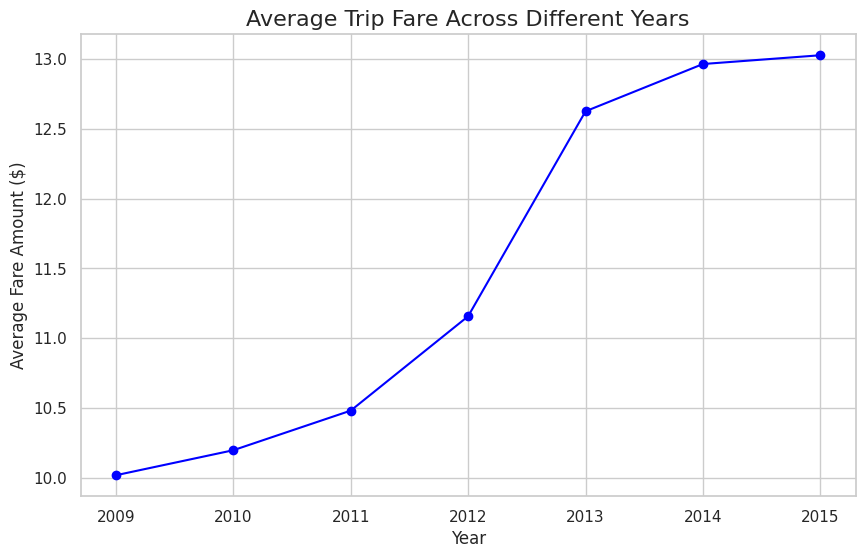

In [ ]:
# Calculate the average fare per year
avg_fare_per_year = data.groupby('year')['fare_amount'].mean()

# Plotting the average fare per year
plt.figure(figsize=(10, 6))
avg_fare_per_year.plot(kind='line', marker='o', color='blue')

# Adding titles and labels
plt.title('Average Trip Fare Across Different Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Fare Amount ($)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=0)
plt.show()


##Data Preprocessing

In [ ]:
# Check the structure and missing values
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 499995 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Car Condition      499995 non-null  float64
 1   Traffic Condition  499995 non-null  float64
 2   fare_amount        499995 non-null  float64
 3   pickup_longitude   499995 non-null  float64
 4   pickup_latitude    499995 non-null  float64
 5   dropoff_longitude  499995 non-null  float64
 6   dropoff_latitude   499995 non-null  float64
 7   passenger_count    499995 non-null  int64  
 8   hour               499995 non-null  int64  
 9   day                499995 non-null  int64  
 10  month              499995 non-null  int64  
 11  weekday            499995 non-null  int64  
 12  year               499995 non-null  int64  
 13  jfk_dist           499995 non-null  float64
 14  ewr_dist           499995 non-null  float64
 15  lga_dist           499995 non-null  float64
 16  sol_dis

In [ ]:
# Function to manually split and extract datetime components
def split_mixed_datetime(datetime_str):
    if ' ' in datetime_str:
        date_part, time_part = datetime_str.split(' ', 1)  # Splitting date and time
    else:
        date_part = datetime_str
        time_part = None

    # Check if the date is in 'day/month/year' format
    if '/' in date_part:
        day, month, year = date_part.split('/')
        year, month, day = int(year), int(month), int(day)
    # Check if the date is in 'year-month-day' format
    elif '-' in date_part:
        year, month, day = date_part.split('-')
        year, month, day = int(year), int(month), int(day)
    else:
        return None

    # Handle time part for '12-hour AM/PM' format or '24-hour' format
    if time_part:
        if 'AM' in time_part or 'PM' in time_part:
            # Handle 'hour:minute:second AM/PM' format
            hour, minute, second_ampm = time_part.split(':')
            second, ampm = second_ampm.split(' ')
            hour = int(hour) % 12 + (12 if ampm == 'PM' else 0)
        else:
            # Handle 'hour:minute:second' format (24-hour)
            hour, minute, second = time_part.split(':')
            hour = int(hour)
        minute, second = int(minute), int(second)
    else:
        hour = minute = second = 0

    return pd.Timestamp(year, month, day, hour, minute, second)

# Apply the split function to the 'pickup_datetime' column (replace with your actual column name)
data['pickup_datetime'] = data['pickup_datetime'].apply(lambda x: split_mixed_datetime(str(x)))

# Extract time features
data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday  # Monday=0, Sunday=6

# Check the first few rows
print(data[['pickup_datetime', 'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday']])

           pickup_datetime  pickup_year  pickup_month  pickup_day  \
0      2009-06-15 17:26:21         2009             6          15   
1      2010-01-05 16:52:16         2010             1           5   
2      2011-08-18 00:35:00         2011             8          18   
3      2012-04-21 04:30:42         2012             4          21   
4      2010-03-09 07:51:00         2010             3           9   
...                    ...          ...           ...         ...   
499995 2015-05-07 18:45:12         2015             5           7   
499996 2010-09-13 12:11:34         2010             9          13   
499997 2014-08-25 00:22:20         2014             8          25   
499998 2015-01-12 12:17:32         2015             1          12   
499999 2010-04-12 23:46:58         2010             4          12   

        pickup_hour  pickup_weekday  
0                17               0  
1                16               1  
2                 0               3  
3                 4

In [ ]:
print("Missing values before handling:")
print(data.isnull().sum())
# Impute numerical columns with mean and categorical with mode
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

Missing values before handling:
User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             5
ewr_dist             5
lga_dist             5
sol_dist             5
nyc_dist             5
distance             5
bearing              5
pickup_year          0
pickup_month         0
pickup_day           0
pickup_hour          0
pickup_weekday       0
dtype: int64


In [ ]:
# Assuming your DataFrame is named 'data'
categorical_cols = ['Weather']
ordinal_cols = ['Traffic Condition', 'Car Condition']

# Create and fit the OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[
    data['Traffic Condition'].unique(),  # Categories for Traffic Condition
    data['Car Condition'].unique()     # Categories for Car Condition
])

# Transform the ordinal columns
data[ordinal_cols] = ordinal_encoder.fit_transform(data[ordinal_cols])

# One-hot encode the remaining categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first') # Use sparse=False
encoded_features = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded columns with original dataset
data = pd.concat([data.drop(categorical_cols, axis=1), encoded_df], axis=1)

In [ ]:
data = data.dropna()

In [ ]:
data = data.drop(['User ID','User Name', 'Driver Name','key'], axis=1)

In [ ]:
data = data.drop('pickup_datetime', axis=1)

In [ ]:
#scaler = StandardScaler()
#numeric_cols = data.select_dtypes(include=[np.number]).columns
#data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
#

In [ ]:
# Separate features and target variable
features = data.drop(columns=['fare_amount'])
target = data['fare_amount']

# Function to detect outliers using IQR
def detect_outliers(df, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outliers = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outliers)
    return list(set(outlier_indices))
# Detect and drop outliers
outliers = detect_outliers(data, features.columns)
data_cleaned = data.drop(outliers, axis=0)
##
#data=data_cleaned

In [ ]:
# Detect numerical features (for scaling) and exclude 'fare_amount'
numeric_features = data_cleaned.select_dtypes(include=[np.number]).drop(columns=['fare_amount']).columns

# Imputation and scaling pipelines for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Fit and transform the numerical features
data_scaled = numeric_transformer.fit_transform(data_cleaned[numeric_features])

# Save the result back to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_features)

# Add back non-numerical features (if any)
non_numeric_features = data_cleaned.select_dtypes(exclude=[np.number]).reset_index(drop=True)
data_scaled_df = pd.concat([data_scaled_df, non_numeric_features], axis=1)

# Add the target column 'fare_amount' back to the DataFrame without scaling it
data_scaled_df['fare_amount'] = data_cleaned['fare_amount'].reset_index(drop=True)
data = data_scaled_df  # Update the original 'data' variable

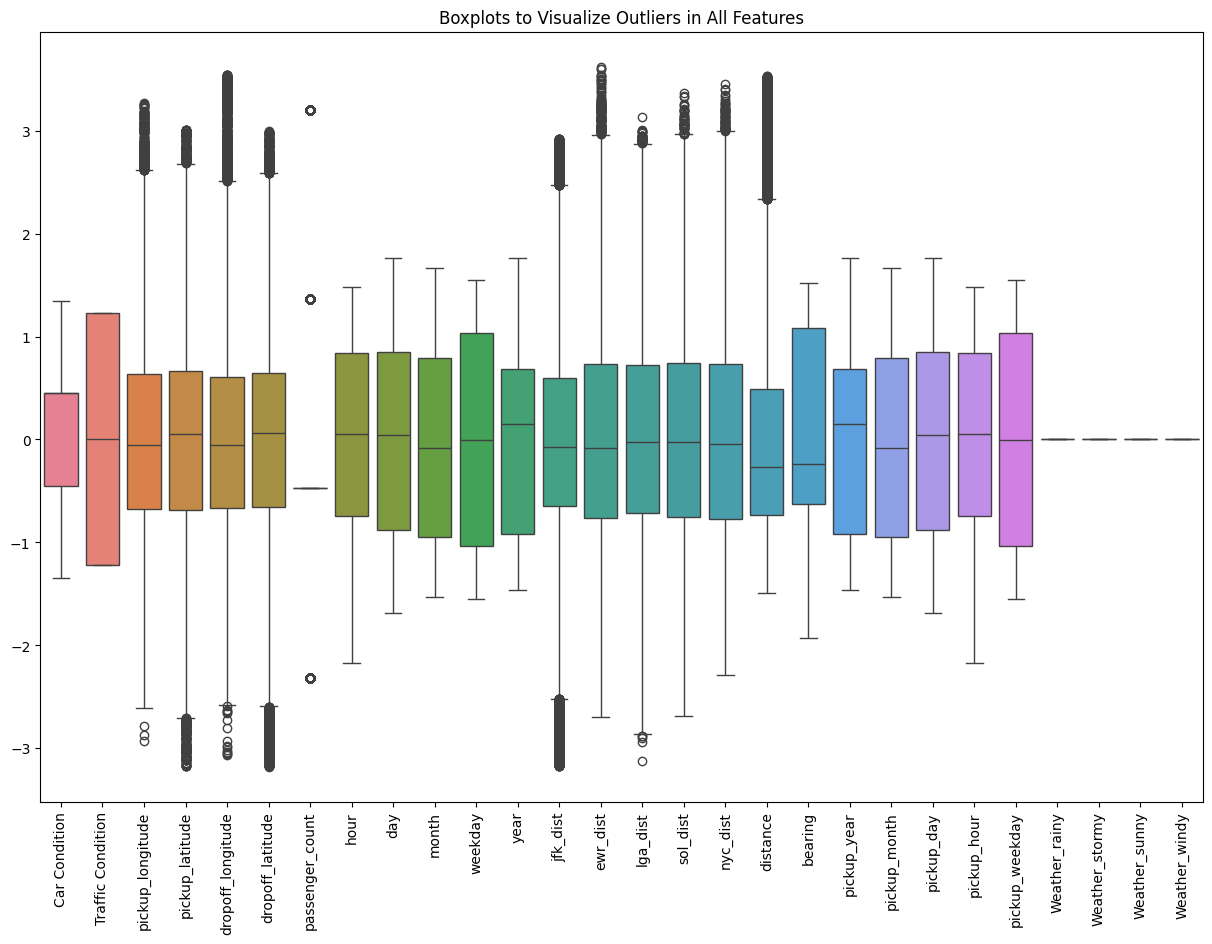

In [ ]:
# Set the size of the plots
plt.figure(figsize=(15, 10))

# Create boxplots for all numerical features
sns.boxplot(data=data[features.columns])  # Assuming 'features.columns' contains the names of the numerical features
plt.title('Boxplots to Visualize Outliers in All Features')
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.show()

In [ ]:
data.head()

,Car Condition,Traffic Condition,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,...,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,Weather_rainy,Weather_stormy,Weather_sunny,Weather_windy,fare_amount
0,0.447004,1.224720,0.368225,-0.375284,-0.521094,-0.668504,1.365965,0.049511,-0.998356,0.791609,...,-0.385113,0.791609,-0.998356,0.049511,-0.519922,0.0,0.0,0.0,0.0,5.7
1,-0.448495,1.224720,-0.507674,0.176820,-0.259711,0.442963,-0.474491,-0.903208,-0.422087,-0.948513,...,1.762937,-0.948513,-0.422087,-0.903208,-0.002263,0.0,0.0,0.0,0.0,4.5
2,-0.448495,1.224720,-0.138447,-0.376584,-0.022825,0.296882,-0.474491,0.208297,1.537229,-0.948513,...,-0.385113,-0.948513,1.537229,0.208297,-1.037581,0.0,0.0,0.0,0.0,8.1
3,-0.448495,1.224720,0.109669,1.491024,0.097508,0.458845,-0.474491,-1.061995,0.845706,-1.528553,...,0.688912,-1.528553,0.845706,-1.061995,-0.519922,0.0,0.0,0.0,0.0,8.0
4,1.342504,-0.000166,-1.418038,-1.777652,-2.174098,-2.173481,-0.474491,0.525870,-0.998356,1.081629,...,0.151900,1.081629,-0.998356,0.525870,1.550714,0.0,0.0,0.0,0.0,7.5


##Feature selection

In [ ]:
#X = data.drop('fare_amount', axis=1)
#y = data['fare_amount']
X_train, X_test=X_train_scaled, X_test_scaled

In [ ]:
def feature_selection_with_k(X_train, X_test, y_train, y_test):
    results = {}
    feature_importances = []

    for k in range(1, 26):
        # Apply SelectKBest with 'k' features
        selector = SelectKBest(score_func=f_regression, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Train a RandomForest Regressor
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_selected, y_train)

        # Get feature importances from the model
        feature_importances.append(model.feature_importances_)

        # Make predictions
        y_pred = model.predict(X_test_selected)

        # Evaluate performance using mean squared error and R2 score
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[k] = (mse, r2)
        print(f"k={k}, MSE: {mse:.4f}, R2: {r2:.4f}")

    return results, feature_importances


# Apply feature selection with different k and get results and feature importances
results, feature_importances = feature_selection_with_k(X_train_scaled, X_test_scaled, y_train, y_test)

k=1, MSE: 18.8328, R2: 0.0624
k=2, MSE: 14.6868, R2: 0.2688
k=3, MSE: 14.6882, R2: 0.2688
k=4, MSE: 9.7918, R2: 0.5125
k=5, MSE: 9.1657, R2: 0.5437
k=6, MSE: 8.7638, R2: 0.5637
k=7, MSE: 8.7121, R2: 0.5663
k=8, MSE: 8.5832, R2: 0.5727
k=9, MSE: 8.1765, R2: 0.5929
k=10, MSE: 8.3372, R2: 0.5849
k=11, MSE: 8.2831, R2: 0.5876
k=12, MSE: 9.9827, R2: 0.5030
k=13, MSE: 9.2336, R2: 0.5403
k=14, MSE: 9.3124, R2: 0.5364
k=15, MSE: 9.6791, R2: 0.5181
k=16, MSE: 9.5648, R2: 0.5238
k=17, MSE: 9.5938, R2: 0.5224
k=18, MSE: 9.3348, R2: 0.5353
k=19, MSE: 9.2532, R2: 0.5393
k=20, MSE: 9.0450, R2: 0.5497
k=21, MSE: 9.7283, R2: 0.5157
k=22, MSE: 9.5641, R2: 0.5239
k=23, MSE: 9.6123, R2: 0.5215
k=24, MSE: 8.0394, R2: 0.5998
k=25, MSE: 8.0390, R2: 0.5998


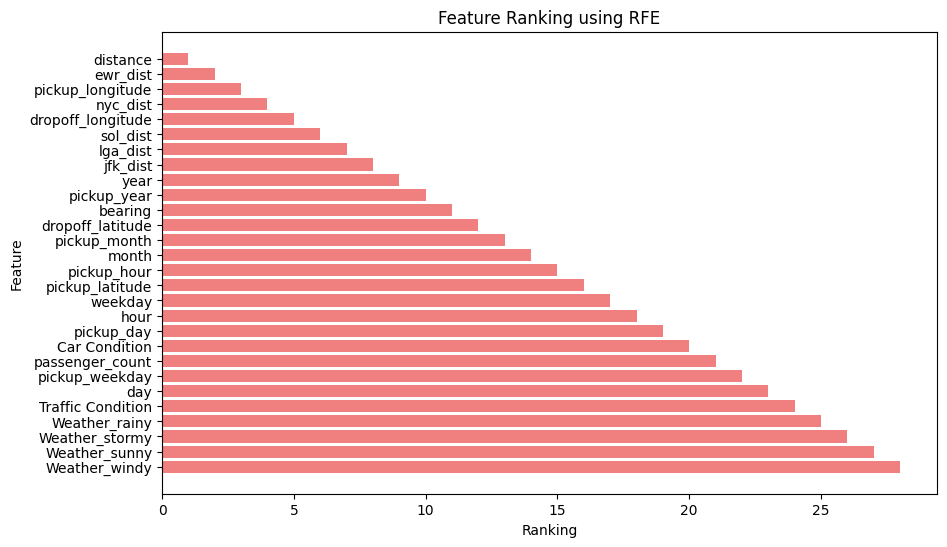

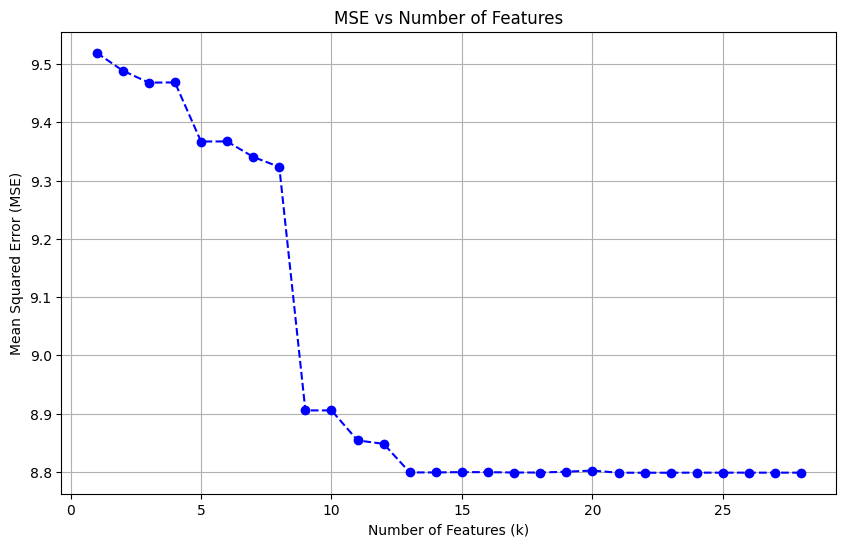

Best number of features: 22


In [ ]:


# Assuming 'data' is your cleaned and scaled dataset
# Separate features and target
X = data.drop(columns=['fare_amount'])
y = data['fare_amount']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
linear_model = LinearRegression()

# Initialize Recursive Feature Elimination (RFE) with Linear Regression
rfe = RFE(estimator=linear_model, n_features_to_select=1)  # Start with selecting 1 feature
rfe.fit(X_train, y_train)

# Get ranking of features
ranking = rfe.ranking_

# Create a DataFrame to view feature rankings
feature_ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': ranking
}).sort_values(by='Ranking')

# Plot feature rankings (lower rank is better)
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Ranking'], color='lightcoral')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.title('Feature Ranking using RFE')
plt.gca().invert_yaxis()
plt.show()

# Now, let's select the best 'k' features by testing performance
mse_scores = []
num_features = np.arange(1, len(X.columns) + 1)

for k in num_features:
    # Perform RFE with 'k' features
    rfe = RFE(estimator=linear_model, n_features_to_select=k)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)

    # Train Linear Regression with selected 'k' features
    linear_model.fit(X_train_rfe, y_train)

    # Make predictions
    y_pred = linear_model.predict(X_test_rfe)

    # Compute Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Plot MSE vs number of features (k)
plt.figure(figsize=(10, 6))
plt.plot(num_features, mse_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Number of Features')
plt.grid()
plt.show()

# Select the best 'k' where MSE is lowest
best_k = num_features[np.argmin(mse_scores)]
print(f"Best number of features: {best_k}")

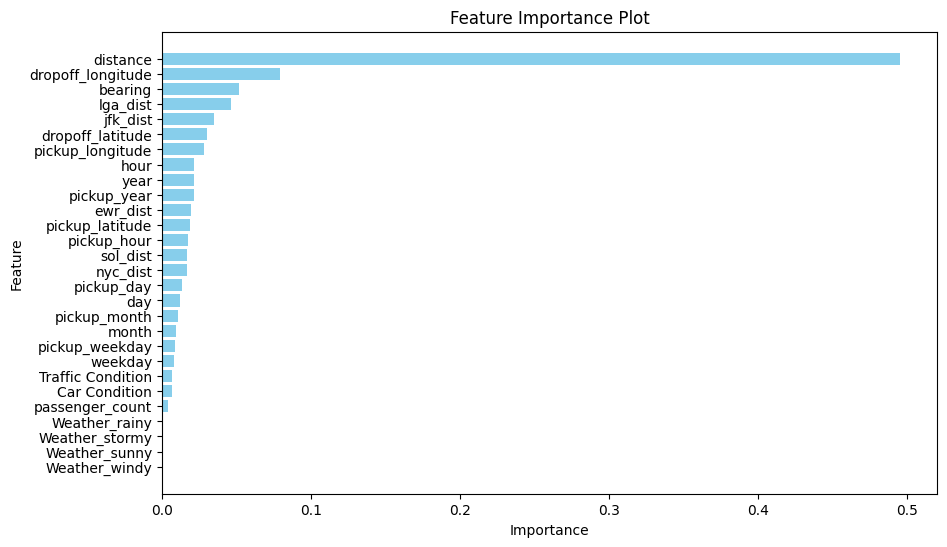

In [ ]:


# Assuming 'data' is your cleaned and scaled dataset
# Separate features and target
X = data.drop(columns=['fare_amount'])
y = data['fare_amount']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
plt.show()

In [ ]:

X = data.drop(columns=['fare_amount'])
y = data['fare_amount']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
selector = SelectKBest(score_func=f_regression, k=9)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['pickup_latitude', 'dropoff_latitude', 'year', 'jfk_dist', 'lga_dist', 'sol_dist', 'distance', 'bearing', 'pickup_year']


##Model Evaluation

In [ ]:

np.random.seed(42)
X_selected = data_scaled_df.drop(columns=['fare_amount'])
y = data_scaled_df['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing and modeling
pipeline = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
#    ('scaler', StandardScaler()),  # Scale features
    ('ridge', Ridge(alpha=0.1))    # Ridge regression
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE with alpha=0.1: {mse:.4f}")
print(f"Test R² with alpha=0.1: {r2:.4f}")


Test MSE with alpha=0.1: 8.7986
Test R² with alpha=0.1: 0.5620


In [ ]:
# Example: Generating random data for demonstration
np.random.seed(42)
X = data.drop(columns=['fare_amount'])
y = data['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "XGBoost": XGBRegressor(random_state=42)  # Add XGBoost
}

# Initialize a list to store results
results_list = []

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the list
    results_list.append({"Model": name, "MSE": mse, "R²": r2})

# Create a DataFrame from the results list
results = pd.DataFrame(results_list)

# Display results
print(results)

# Find and display the best model based on R²
best_model = results.loc[results['R²'].idxmax()]
print(f'\nBest Model: {best_model["Model"]}')
print(f'MSE: {best_model["MSE"]:.4f}, R²: {best_model["R²"]:.4f}')


                       Model        MSE        R²
0          Linear Regression   8.798814  0.561960
1           Ridge Regression   8.797440  0.562029
2           Lasso Regression  10.660519  0.469277
3              Random Forest   8.087959  0.597349
4          Gradient Boosting   7.539524  0.624653
5  Support Vector Regression   7.845343  0.609428
6                    XGBoost  17.210720  0.143182

Best Model: Gradient Boosting
MSE: 7.5395, R²: 0.6247


Test MSE with XGBoost: 3.7189
Test R² with XGBoost: 0.9924


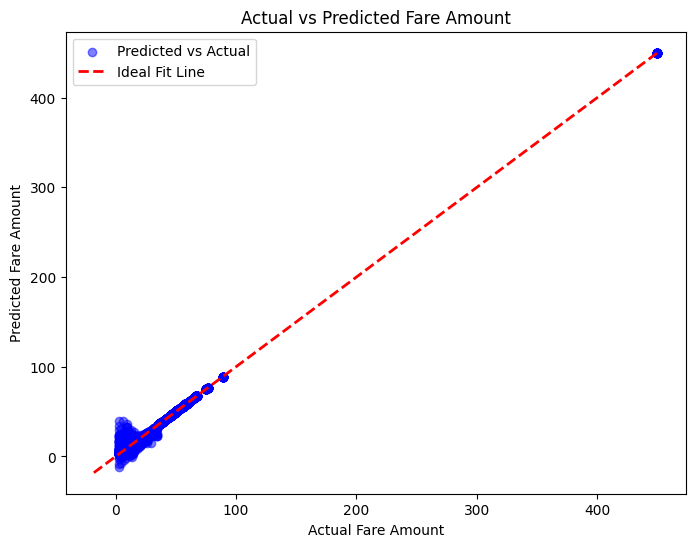

In [ ]:
np.random.seed(42)
X_selected = data[selected_features]
y = data['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model with specified hyperparameters
xgb_model = XGBRegressor(n_estimators=700, learning_rate=0.05, max_depth=40, objective='reg:squarederror', random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE with XGBoost: {mse:.4f}")
print(f"Test R² with XGBoost: {r2:.4f}")

# Plotting actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label="Ideal Fit Line")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount")
plt.legend()
plt.show()


Test MSE with XGBoost: 3.7189
Test R² with XGBoost: 0.9924


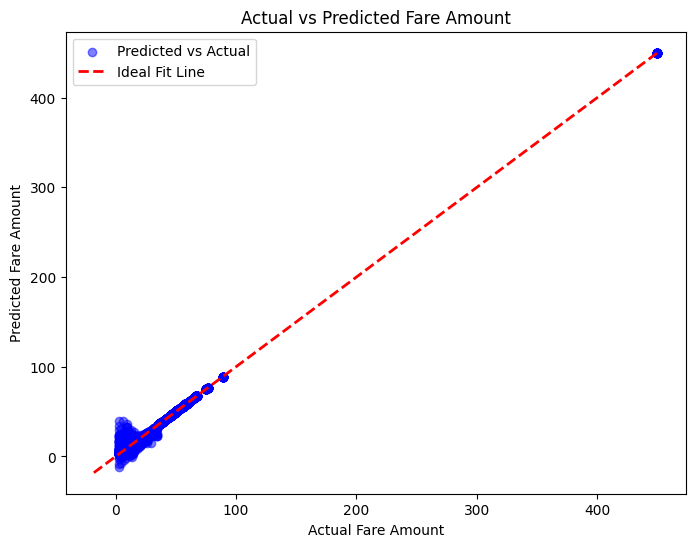

In [ ]:
np.random.seed(42)
X_selected = data[selected_features]
y = data['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model with specified hyperparameters
xgb_model = XGBRegressor(n_estimators=700, learning_rate=0.05, max_depth=10, objective='reg:squarederror', random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE with XGBoost: {mse:.4f}")
print(f"Test R² with XGBoost: {r2:.4f}")

# Plotting actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label="Ideal Fit Line")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount")
plt.legend()
plt.show()


## Hyperparameter tuning

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Test MSE with tuned XGBoost: 2.9078
Test R² with tuned XGBoost: 0.9940


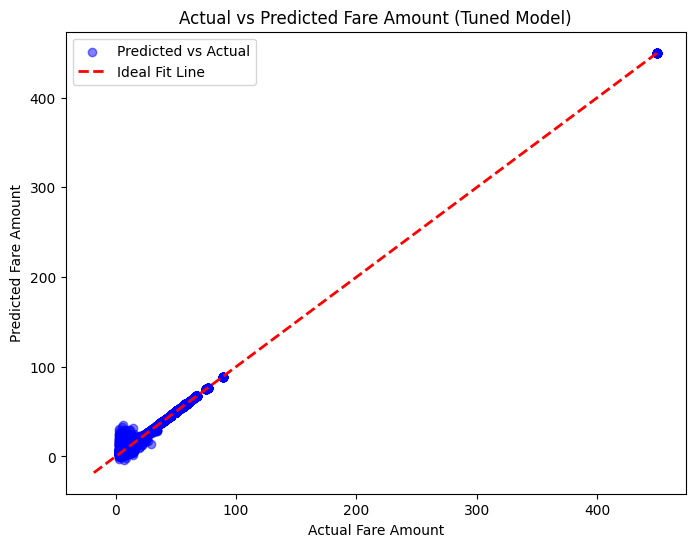

In [ ]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

np.random.seed(42)
X_selected = data[selected_features]
y = data['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10, 15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}


# Initialize the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Adjust based on time constraints; higher values provide better results
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Retrieve the best model
best_xgb_model = random_search.best_estimator_

# Predict on the test data
y_pred = best_xgb_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print(f"Test MSE with tuned XGBoost: {mse:.4f}")
print(f"Test R² with tuned XGBoost: {r2:.4f}")

# Plotting actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label="Ideal Fit Line")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount (Tuned Model)")
plt.legend()
plt.show()


##Export Model

In [ ]:


def scale_data(data_cleaned):
    # Detect numerical features (for scaling) and exclude 'fare_amount'
    numeric_features = data_cleaned.select_dtypes(include=[np.number]).drop(columns=['fare_amount']).columns

    # Imputation and scaling pipelines for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Fit and transform the numerical features
    data_scaled = numeric_transformer.fit_transform(data_cleaned[numeric_features])

    # Save the result back to a DataFrame
    data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_features)

    # Add back non-numerical features (if any)
    non_numeric_features = data_cleaned.select_dtypes(exclude=[np.number]).reset_index(drop=True)
    data_scaled_df = pd.concat([data_scaled_df, non_numeric_features], axis=1)

    # Add the target column 'fare_amount' back to the DataFrame without scaling it
    data_scaled_df['fare_amount'] = data_cleaned['fare_amount'].reset_index(drop=True)

    # Update the original 'data' variable
    return data_scaled_df

# Example usage and saving the function
joblib.dump(scale_data, 'scale_data_function.joblib')
# Load the function from joblib
scale_data = joblib.load('scale_data_function.joblib')

# Assuming data_cleaned is your DataFrame
data_scaled_df = scale_data(data[['passenger_count', 'hour', 'month', 'year', 'distance', 'bearing', 'pickup_year', 'pickup_month', 'pickup_hour','fare_amount']])
# Load the function from joblib
scale_data = joblib.load('scale_data_function.joblib')

# Assuming data_cleaned is your DataFrame
data_scaled_df = scale_data(data_cleaned)

In [ ]:
def scale_data(data_cleaned):
    # Detect numeric features, assuming 'fare_amount' is already excluded
    numeric_features = data_cleaned.select_dtypes(include=[np.number]).columns

    # Set up pipeline for imputation and scaling of numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Fit and transform the numeric features
    data_scaled = numeric_transformer.fit_transform(data_cleaned[numeric_features])

    # Place the scaled data back into a DataFrame with the correct columns
    data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_features)

    # Concatenate non-numeric features if they exist
    non_numeric_features = data_cleaned.select_dtypes(exclude=[np.number]).reset_index(drop=True)
    if not non_numeric_features.empty:
        data_scaled_df = pd.concat([data_scaled_df, non_numeric_features], axis=1)

    return data_scaled_df

# Save the function for future use
joblib.dump(scale_data, 'scale_data_function.joblib')

# Load the function from joblib
scale_data = joblib.load('scale_data_function.joblib')

# Apply scaling to the data using selected features (excluding 'fare_amount')
data_scaled_df = scale_data(data[selected_features])

# Add the 'fare_amount' column back to the scaled DataFrame without scaling
data_scaled_df['fare_amount'] = data['fare_amount'].reset_index(drop=True)


In [ ]:
# Add the target column 'fare_amount' back to the DataFrame without scaling it
data_scaled_df['fare_amount'] = data['fare_amount'].reset_index(drop=True)


In [ ]:
data_scaled_df.head()

,passenger_count,hour,month,year,distance,bearing,pickup_year,pickup_month,pickup_hour,fare_amount
0,-0.522755,0.535838,-0.078136,-1.471942,-0.050199,-1.782188,-1.471942,-0.078136,0.535838,4.5
1,-0.522755,0.382266,-1.532557,-0.934566,-0.029999,-0.372593,-0.934566,-1.532557,0.382266,16.9
2,0.242128,-2.074892,0.503632,-0.397190,-0.049222,1.276119,-0.397190,0.503632,-2.074892,5.7
3,-0.522755,-1.460602,-0.659905,0.140186,-0.045384,-0.090460,0.140186,-0.659905,-1.460602,7.7
4,-0.522755,-0.999885,-0.950789,-0.934566,-0.047562,-0.443240,-0.934566,-0.950789,-0.999885,5.3


In [ ]:


np.random.seed(42)
X_selected = data_scaled_df.drop(columns=['fare_amount'])
y = data_scaled_df['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing and modeling
pipeline = Pipeline(steps=[
    # Uncomment if you want to include preprocessing steps
    # ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    # ('scaler', StandardScaler()),  # Scale features
    ('xgb', XGBRegressor(n_estimators=700, learning_rate=0.05, max_depth=10, objective='reg:squarederror', random_state=42))  # XGBoost regressor
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x78291ef07430>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


In [ ]:
# Save the entire pipeline to a file
joblib.dump(pipeline, 'ridge_pipeline.joblib')
print("Pipeline saved as 'ridge_pipeline.joblib'")


Pipeline saved as 'ridge_pipeline.joblib'
